In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import scipy as sp 
import sys
import os
from collections import OrderedDict
import argparse
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import  squareform
from scipy.stats import percentileofscore

sys.path.insert(0 , "../codes")
from IOutils import loadCellData, readListFromFile
import clusterByMeanExpr as clFuncs 

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
%matplotlib inline 
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] =  "large"
plt.rcParams["ytick.labelsize"] =  "large"
plt.rcParams["legend.fontsize"] = "x-large"

In [2]:
#############################################
## FUNCTION DEFINITIONS
def clusterDict_from_dendrogram( Z_dendro, observations ):
    """
    Input:
        Z_dendro - output of scipy.cluster.hierarchy.dendrogram. A dictionary with keys - 
                    'color_list' , 'icoord', 'dcoord', 'leaves'
        observations - Labels of rows/ columns of distance matrix used for clustering
    Returns
        clustLabelDict - Keys are cluster colors , values are list of observations
                        belonging to cluster
    """
    clustID_leafXlabels = []
    for color, Icoord , Dcoord in zip(  Z_dendro['color_list'],   Z_dendro["icoord"],  Z_dendro["dcoord"]) :
        if Dcoord[0] ==0.0:
            clustID_leafXlabels.append(( color , Icoord[0]   )  )
        if Dcoord[-1] ==0.0:
            clustID_leafXlabels.append(( color , Icoord[-1]  ) )

    clustID_leafXlabels =  sorted( clustID_leafXlabels , key = lambda x: x[1] )
    clusterLabels = set( [ elem[0] for elem in  clustID_leafXlabels  ] )
    observations_ordered = list(np.array(observations)[Z_dendro['leaves']] )                                       
    clustLabelDict =  { clustLabel : 
                       [ observations_ordered[i]  for i , elem in enumerate( clustID_leafXlabels ) if elem[0] == clustLabel]  \
                       for clustLabel in  clusterLabels  }
    return  clustLabelDict

def getNull_maxSize( exprByStage_means , nClusts = 3 , nPerms =  500,
                               linkageMethod = "complete"):
    """ 
    Inputs:
        exprByStage_means  -Dataframe ,Each row is a gene,  each column is an observation (stage)
        ...
    Returns:
        nullDistrib - (nPerms , nCust) each row are cluster sizes of one simulation
                        sorted from largest to smallest
    """
    
    def get_maxClustSize(toCluster , nClusts= 3, linkageMethod = "complete"):
        """ 
        toCluster - array, rows are observations columns are variables
        """
        #dists = pdist( toCluster , metric = "correlation"  )
        #Y = sch.linkage(dists ,linkageMethod )
        #fclust = sch.fcluster( Y , nClusts , criterion = 'maxclust' )
        dists = 1.0 - np.corrcoef(toCluster , rowvar = True )
        ## symmetrize
        dists =  dists/2.0 + dists.transpose()/2.0
        dists[np.diag_indices(dists.shape[0])] = 0.0 
        Y = sch.linkage(squareform(dists), method= linkageMethod)
        fclust = sch.fcluster( Y , nClusts , criterion = 'maxclust' )
        unique , counts = np.unique(fclust ,return_counts= True)
        
        assert( len(unique) == nClusts  )
        rVal = sorted(counts, reverse= True)
        return rVal 
    
    nullDistrib = np.zeros((nPerms , nClusts) , dtype = int )
    exprByStage_means_values = np.copy(exprByStage_means.values)
    for permIdx in range(nPerms):
        for i in range( exprByStage_means_values.shape[0]):
            np.random.shuffle(exprByStage_means_values[ i, : ] )
        nullDistrib[permIdx , :] = get_maxClustSize(toCluster = exprByStage_means_values,
                                              nClusts= nClusts, linkageMethod = linkageMethod)
    return nullDistrib

In [3]:
#### Parse command-line ####################################################################################
parser = argparse.ArgumentParser(description='Cluster gene set by correlation in mean expression across modules')
parser.add_argument("--exprTable" )
parser.add_argument("--cells_allowed")
parser.add_argument( "--stageLabels" )
parser.add_argument("--stagesAllowed" , help="comma separated list of ints")
parser.add_argument("--fi_genes", default = "" , help =  "file listing gene names(1 per line). If comma sep list take union")
parser.add_argument("--minExpr" , type = float)
parser.add_argument('--minLog2FC', type = float ,
                    help= "Minimum magnitude of log2FC (between 2 stages) for gene to be considered in anaylsis")
parser.add_argument('--linkage' , default = "complete" )
parser.add_argument('--outDir' )

exampleInput = "--exprTable ../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl \
--cells_allowed ../exprCorr/cellNames.passFilter.txt \
--stageLabels ../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv \
--fi_genes  ../raw/amigo2_antiOxidant-genesAndGeneProducts.symb.converted.Geq1percent.txt \
--stagesAllowed 1,2,3,4,5,6,7 \
--minExpr 0.05 \
--minLog2FC 1.0 \
--linkage average \
--outDir ."

args = parser.parse_args(exampleInput.split())
stagesAllowed = [int(x) for x in args.stagesAllowed.split(",")]

In [4]:
############################################################################################
#### LOAD DATA 
exprDF = loadCellData( fnameDict = OrderedDict([ ("expr", args.exprTable ) , ("pcComps" , args.stageLabels)] ) )
geneNames = readListFromFile(args.fi_genes)
cells_pass = readListFromFile(args.cells_allowed)
exprDF = exprDF.loc[cells_pass, :].copy()

loading Files
	loading file ../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl
	loading file ../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv
Summary of Join:
	expr : 22338 of 22338 in join
	pcComps : 22338 of 22338 in join


In [5]:
#########################################################################################################
### PREPROCESS
## Stagewise mean
meanExpr = exprDF["expr"].groupby( by = exprDF["rowData"].loc[: , "clust_ID"] ).apply(lambda x: x.mean(axis = 0))
meanExpr = meanExpr.loc[stagesAllowed, geneNames].copy()

## filter by log2FC
if args.minLog2FC is not None:
    if args.minExpr is not None:
        print("Filtering genes list to those with magnituded logFC geq {} (enforcing min expression {} in LFCcalc)".format(args.minLog2FC, args.minExpr)  )
        lfcMaxMin = meanExpr.apply( lambda x: np.log2(x.max()/ max(x.min(), args.minExpr ) ) , axis = 0)
    else:
        print("Filtering genes list to those with magnituded logFC geq {}".format(args.minLog2FC )  )
        lfcMaxMin = meanExpr.apply( lambda x: np.log2(x.max()/ x.min()) , axis = 0) 
    mask =  lfcMaxMin < args.minLog2FC
    meanExpr = meanExpr.loc[: , ~mask].copy()
    print("{} of {} gene candidiates remain after LFC filter".format(meanExpr.shape[1] , len(geneNames)))
    
## Convert to z-score of logTPM of stagewise means
meanExpr = np.log10(meanExpr*100.0 + 1.0)
plotData = ((meanExpr.subtract(meanExpr.mean(axis = 0), axis =1)).divide( meanExpr.std(axis = 0) , axis =1 )).transpose()

Filtering genes list to those with magnituded logFC geq 1.0 (enforcing min expression 0.05 in LFCcalc)
32 of 65 gene candidiates remain after LFC filter


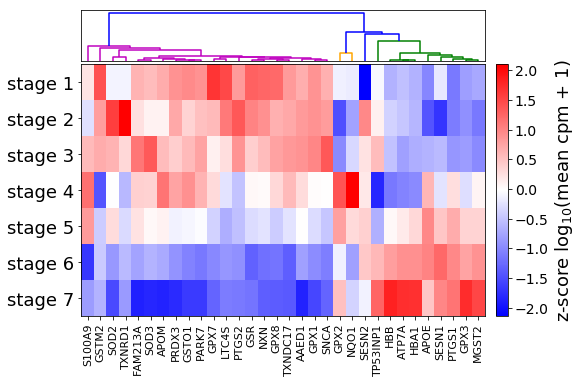

In [6]:
#########################################################################################################
### Cluster
dists = pdist( plotData.values.copy(), metric = "correlation"  )
linkageMat = sch.linkage(dists , method= args.linkage)

cbarLabel = 'z-score $\log_{10}$(mean cpm + 1)'

if type(plotData.columns[0]) is np.int64:
    plotData.rename(columns = {i : "stage {:d}".format(i) for i in plotData.columns} , inplace = True)

#linkageMat[-1, [0,1]] = linkageMat[-1, [1,0]] ## put magenta cluster 1st from left to right in dendrogram
fig , Z = clFuncs.clusterHmap(data =plotData.copy() , linkageMat= linkageMat , 
                cmap = plt.cm.bwr,
                cbarLabel =  cbarLabel , 
                xtickLabelFontsize = 11 ,
                ytickLabelFontsize = 18 , grid_lw=2 ,
               cbarLabelSize = 18, cbarTickLabelSize = 14 , color_threshold = 0.68  ,
               figsize=(8, 5), colorMinMaxPct = None, dendroColorPalette  = ["m" , "orange", 'g'] )

exprClusts_dict = clusterDict_from_dendrogram( Z_dendro = Z, observations  = list(plotData.index))

os.makedirs(args.outDir ,exist_ok = True )
fig.savefig(os.path.join(args.outDir , "clustMap.pdf"), bbox_inches = "tight" , format ="pdf" )
for k ,v in exprClusts_dict.items():
    f = open(os.path.join(args.outDir ,  k + "_genes.txt" ) , 'w' )
    for x in v:
        f.write(x + "\n")
    f.close()

In [8]:
## Get mageta cluster size enrichment p-value
null = getNull_maxSize( exprByStage_means = plotData.copy(), nClusts = 4 , nPerms =  100000,
                               linkageMethod = args.linkage)

m_size = len(exprClusts_dict["m"])
p = 1.0 - percentileofscore(null[:, 0] , 22 )/100.0
print("p value of size {} in null distribution is {:.4e}".format(m_size, p))
f = open(os.path.join(args.outDir, "pVal.txt") , 'w')
f.write("p={:.3e}\n".format(p))
f.close()

p value of size 20 in null distribution is 8.5000e-04
